In [4]:
# ===============================
# 1. IMPORT LIBRARIES
# ===============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ===============================
# 2. LOAD DATASET
# (Upload simple_uplift_dataset.csv to Colab first)
# ===============================
df = pd.read_csv("simple_uplift_dataset.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (20000, 6)


,x1,x2,x3,x4,treatment,target
0,0.177999,1.441526,4,A,1,1
1,1.202127,1.429801,2,C,0,0
2,1.368583,0.071323,1,A,0,0
3,0.336085,-0.158093,3,B,1,0
4,-0.449108,-0.082635,0,C,1,0


In [5]:
# Encode categorical columns
categorical_cols = df.select_dtypes(include=["object"]).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_encoded.head()


,x1,x2,x3,treatment,target,x4_B,x4_C
0,0.177999,1.441526,4,1,1,False,False
1,1.202127,1.429801,2,0,0,False,True
2,1.368583,0.071323,1,0,0,False,False
3,0.336085,-0.158093,3,1,0,True,False
4,-0.449108,-0.082635,0,1,0,False,True


In [6]:
X = df_encoded.drop(["target", "treatment"], axis=1)
y = df_encoded["target"]
t = df_encoded["treatment"]

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.3, random_state=42, stratify=t
)


In [7]:
# Add treatment as feature
X_train_s = X_train.copy()
X_train_s["treatment"] = t_train

s_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
s_model.fit(X_train_s, y_train)

# Predict outcomes for T=1 and T=0
X_test_t1 = X_test.copy()
X_test_t1["treatment"] = 1

X_test_t0 = X_test.copy()
X_test_t0["treatment"] = 0

cate_s = s_model.predict(X_test_t1) - s_model.predict(X_test_t0)


In [8]:
model_treat = GradientBoostingRegressor(n_estimators=200, max_depth=3)
model_control = GradientBoostingRegressor(n_estimators=200, max_depth=3)

model_treat.fit(X_train[t_train == 1], y_train[t_train == 1])
model_control.fit(X_train[t_train == 0], y_train[t_train == 0])

cate_t = model_treat.predict(X_test) - model_control.predict(X_test)


In [9]:
def qini_curve(y_true, treatment, cate):
    df_eval = pd.DataFrame({
        "y": y_true,
        "t": treatment,
        "cate": cate
    })
    df_eval = df_eval.sort_values("cate", ascending=False).reset_index(drop=True)

    cum_treat = df_eval["t"].cumsum()
    cum_control = (~df_eval["t"].astype(bool)).cumsum()

    cum_y_treat = (df_eval["y"] * df_eval["t"]).cumsum()
    cum_y_control = (df_eval["y"] * (1 - df_eval["t"])).cumsum()

    uplift = (cum_y_treat / cum_treat.replace(0, np.nan)) - \
             (cum_y_control / cum_control.replace(0, np.nan))

    fraction = np.arange(1, len(df_eval)+1) / len(df_eval)

    return fraction, uplift.fillna(0)


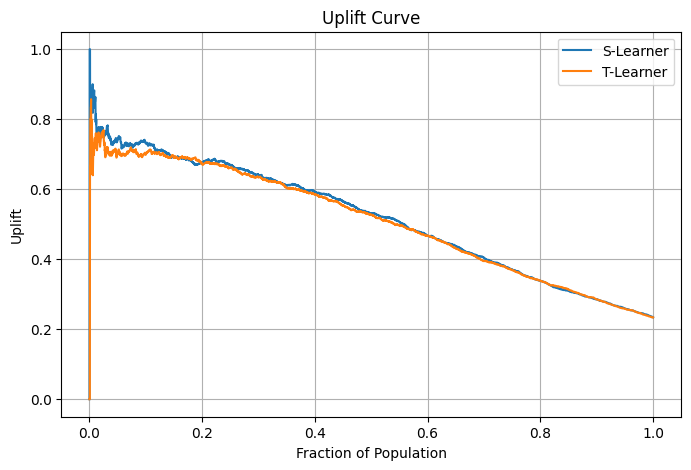

In [12]:
plt.figure(figsize=(8,5))
plt.plot(frac_s, upl_s, label="S-Learner")
plt.plot(frac_t, upl_t, label="T-Learner")
plt.xlabel("Fraction of Population")
plt.ylabel("Uplift")
plt.title("Uplift Curve")
plt.legend()
plt.grid(True)
plt.show()



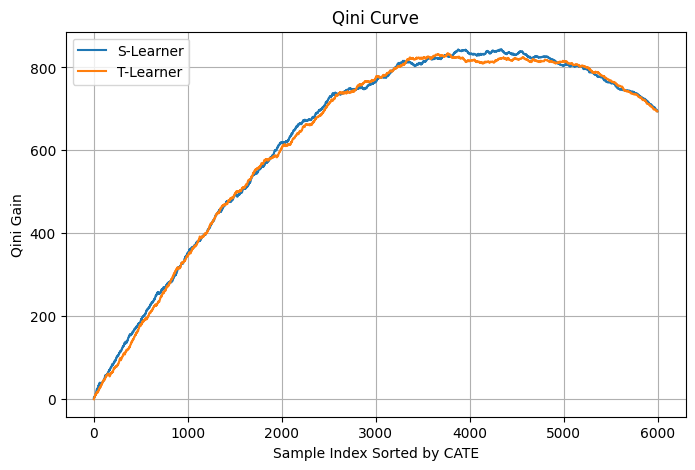

In [13]:
def qini_values(y_true, treatment, cate):
    df_temp = pd.DataFrame({"y": y_true, "t": treatment, "cate": cate})
    df_temp = df_temp.sort_values("cate", ascending=False)

    df_temp["treated_y"] = df_temp["y"] * df_temp["t"]
    df_temp["control_y"] = df_temp["y"] * (1 - df_temp["t"])

    df_temp["cum_t"] = df_temp["t"].cumsum()
    df_temp["cum_c"] = (1 - df_temp["t"]).cumsum()

    df_temp["cum_y_t"] = df_temp["treated_y"].cumsum()
    df_temp["cum_y_c"] = df_temp["control_y"].cumsum()

    qini = df_temp["cum_y_t"] - df_temp["cum_y_c"]
    return np.arange(len(qini)), qini

x_s, q_s = qini_values(y_test, t_test, cate_s)
x_t, q_t = qini_values(y_test, t_test, cate_t)

plt.figure(figsize=(8,5))
plt.plot(x_s, q_s, label="S-Learner")
plt.plot(x_t, q_t, label="T-Learner")
plt.xlabel("Sample Index Sorted by CATE")
plt.ylabel("Qini Gain")
plt.title("Qini Curve")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Subgroup A: x1 > 0
# Subgroup B: x1 <= 0

subgroup_A = X_test["x1"] > 0
subgroup_B = ~subgroup_A

print("Avg CATE (S-Learner) - A:", cate_s[subgroup_A].mean())
print("Avg CATE (S-Learner) - B:", cate_s[subgroup_B].mean())

print("Avg CATE (T-Learner) - A:", cate_t[subgroup_A].mean())
print("Avg CATE (T-Learner) - B:", cate_t[subgroup_B].mean())


Avg CATE (S-Learner) - A: 0.4007086496780994
Avg CATE (S-Learner) - B: 0.04971670735658456
Avg CATE (T-Learner) - A: 0.4079523127626089
Avg CATE (T-Learner) - B: 0.04615569535165632
